In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


In [2]:
# HIDE OUTPUT
!git clone https://github.com/NVlabs/stylegan3.git
!pip install ninja

fatal: destination path 'stylegan3' already exists and is not an empty directory.


In [3]:
!ls /content/stylegan3


avg_spectra.py	 Dockerfile	  gen_video.py	metrics      training
calc_metrics.py  docs		  gui_utils	__pycache__  train.py
dataset_tool.py  environment.yml  legacy.py	README.md    visualizer.py
dnnlib		 gen_images.py	  LICENSE.txt	torch_utils  viz


In [4]:
# HIDE OUTPUT
URL = "https://api.ngc.nvidia.com/v2/models/nvidia/research/"\
      "stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"

!python /content/stylegan3/gen_images.py \
    --network={URL} \
  --outdir=/content/results --seeds=6600-6625

Loading networks from "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"...
Generating image for seed 6600 (0/26) ...
/content/stylegan3/gen_images.py:137: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').save(f'{outdir}/seed{seed:04d}.png')
Generating image for seed 6601 (1/26) ...
Generating image for seed 6602 (2/26) ...
Generating image for seed 6603 (3/26) ...
Generating image for seed 6604 (4/26) ...
Generating image for seed 6605 (5/26) ...
Generating image for seed 6606 (6/26) ...
Generating image for seed 6607 (7/26) ...
Generating image for seed 6608 (8/26) ...
Generating image for seed 6609 (9/26) ...
Generating image for seed 6610 (10/26) ...
Generating image for seed 6611 (11/26) ...
Generating image for seed 6612 (12/26) ...
Generating image for seed 6613 (13/26) ...
Generating image for seed 6614 (14/26) ...
Gene

In [5]:
# Fix: Modify upfirdn2d.py to use the reference (CPU) implementation for upfirdn2d.
# This bypasses the problematic CUDA plugin compilation.
!sed -i "s/impl='cuda'/impl='ref'/g" /content/stylegan3/torch_utils/ops/upfirdn2d.py

print("Modified 'upfirdn2d.py' to use the reference implementation.")
print("Please re-run the cells that load the StyleGAN3 network and generate images (cells Qb77_CIOy8fn and A9qGIJ_7zAI3).")

Modified 'upfirdn2d.py' to use the reference implementation.
Please re-run the cells that load the StyleGAN3 network and generate images (cells Qb77_CIOy8fn and A9qGIJ_7zAI3).


In [6]:
# Fix: Modify filtered_lrelu.py to use the reference (CPU) implementation for filtered_lrelu.
# This bypasses the problematic CUDA plugin compilation.
!sed -i "s/impl='cuda'/impl='ref'/g" /content/stylegan3/torch_utils/ops/filtered_lrelu.py

print("Modified 'filtered_lrelu.py' to use the reference implementation.")
print("Please re-run the cells that load the StyleGAN3 network and generate images (cells Qb77_CIOy8fn and A9qGIJ_7zAI3).")

Modified 'filtered_lrelu.py' to use the reference implementation.
Please re-run the cells that load the StyleGAN3 network and generate images (cells Qb77_CIOy8fn and A9qGIJ_7zAI3).


In [7]:
# Fix: Modify bias_act.py to use the reference (CPU) implementation for bias_act.
# This bypasses the problematic CUDA plugin compilation.
!sed -i "s/impl='cuda'/impl='ref'/g" /content/stylegan3/torch_utils/ops/bias_act.py

print("Modified 'bias_act.py' to use the reference implementation.")
print("Please re-run the cells that load the StyleGAN3 network and generate images (cells Qb77_CIOy8fn and A9qGIJ_7zAI3).")

Modified 'bias_act.py' to use the reference implementation.
Please re-run the cells that load the StyleGAN3 network and generate images (cells Qb77_CIOy8fn and A9qGIJ_7zAI3).


In [8]:
!ls /content/results


seed6600.png  seed6606.png  seed6612.png  seed6618.png	seed6624.png
seed6601.png  seed6607.png  seed6613.png  seed6619.png	seed6625.png
seed6602.png  seed6608.png  seed6614.png  seed6620.png
seed6603.png  seed6609.png  seed6615.png  seed6621.png
seed6604.png  seed6610.png  seed6616.png  seed6622.png
seed6605.png  seed6611.png  seed6617.png  seed6623.png


In [9]:
!cp /content/results/* \
    /content/drive/My\ Drive/projects/stylegan3

cp: target '/content/drive/My Drive/projects/stylegan3' is not a directory


In [10]:
import sys
sys.path.insert(0, "/content/stylegan3")
import pickle
import os
import numpy as np
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt
import IPython.display
import torch
import dnnlib
import legacy

def seed2vec(G, seed):
  return np.random.RandomState(seed).randn(1, G.z_dim)

def display_image(image):
  plt.axis('off')
  plt.imshow(image)
  plt.show()

def generate_image(G, z, truncation_psi):
    # Render images for dlatents initialized from random seeds.
    Gs_kwargs = {
        'output_transform': dict(func=tflib.convert_images_to_uint8,
         nchw_to_nhwc=True),
        'randomize_noise': False
    }
    if truncation_psi is not None:
        Gs_kwargs['truncation_psi'] = truncation_psi

    label = np.zeros([1] + G.input_shapes[1][1:])
    # [minibatch, height, width, channel]
    images = G.run(z, label, **G_kwargs)
    return images[0]

def get_label(G, device, class_idx):
  label = torch.zeros([1, G.c_dim], device=device)
  if G.c_dim != 0:
      if class_idx is None:
          ctx.fail("Must specify class label with --class when using "\
            "a conditional network")
      label[:, class_idx] = 1
  else:
      if class_idx is not None:
          print ("warn: --class=lbl ignored when running on "\
            "an unconditional network")
  return label

def generate_image(device, G, z, truncation_psi=1.0, noise_mode='const',
                   class_idx=None):
  z = torch.from_numpy(z).to(device)
  label = get_label(G, device, class_idx)
  img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
  img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(\
      torch.uint8)
  return PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')

In [11]:
URL = "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/"\
  "versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"

print(f'Loading networks from "{URL}"...')
device = torch.device('cuda')
with dnnlib.util.open_url(URL) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

Loading networks from "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhq-1024x1024.pkl"...


Seed 1000


/tmp/ipython-input-2405075806.py:57: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')


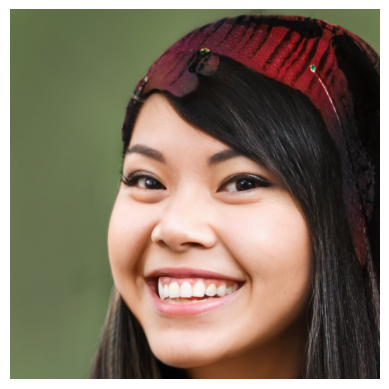

Seed 1001


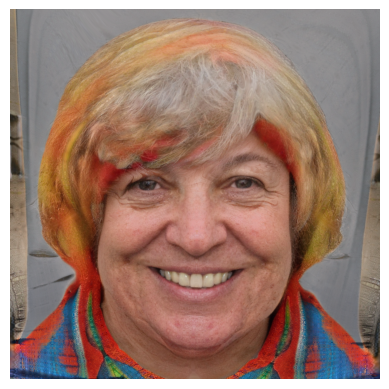

Seed 1002


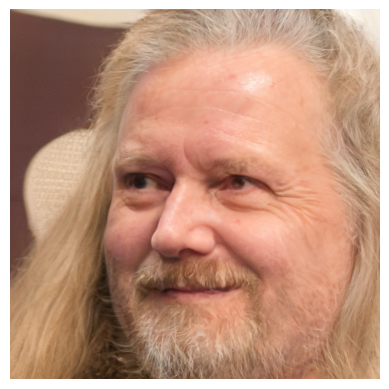

In [12]:
# Choose your own starting and ending seed.
SEED_FROM = 1000
SEED_TO = 1003

# Generate the images for the seeds.
for i in range(SEED_FROM, SEED_TO):
  print(f"Seed {i}")
  z = seed2vec(G, i)
  img = generate_image(device, G, z)
  display_image(img)

In [13]:
# Re-apply fix for bias_act.py after restart
!sed -i "s/impl='cuda'/impl='ref'/g" /content/stylegan3/torch_utils/ops/bias_act.py
print("Re-applied fix for 'bias_act.py'.")

Re-applied fix for 'bias_act.py'.


In [14]:
# Re-apply fix for filtered_lrelu.py after restart
!sed -i "s/impl='cuda'/impl='ref'/g" /content/stylegan3/torch_utils/ops/filtered_lrelu.py
print("Re-applied fix for 'filtered_lrelu.py'.")

Re-applied fix for 'filtered_lrelu.py'.


In [15]:
# Re-apply fix for upfirdn2d.py after restart
!sed -i "s/impl='cuda'/impl='ref'/g" /content/stylegan3/torch_utils/ops/upfirdn2d.py
print("Re-applied fix for 'upfirdn2d.py'.")

Re-applied fix for 'upfirdn2d.py'.
